In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
#from helpers import *
import plotly.express as px
from datetime import datetime
import statsmodels.formula.api as smf
import os

In [45]:
#import data
dfeu = pd.read_csv('DATA/eu.tsv',sep='\t')
dfeu.head()

,"s_adj,age,unit,sex,geo\time",2020M07,2020M06,2020M05,2020M04,2020M03,2020M02,2020M01,2019M12,2019M11,...,1983M10,1983M09,1983M08,1983M07,1983M06,1983M05,1983M04,1983M03,1983M02,1983M01
0,"NSA,TOTAL,PC_ACT,F,AT",6.0,6.2,5.2,4.9,4.7,4.1,4.4,4.0,3.9,...,:,:,:,:,:,:,:,:,:,:
1,"NSA,TOTAL,PC_ACT,F,BE",5.4,5.0,5.0,5.2,5.0,4.9,4.8,4.6,4.5,...,:,:,:,:,:,:,:,:,:,:
2,"NSA,TOTAL,PC_ACT,F,BG",3.9,3.9,4.2,4.7,4.1,4.2,4.3,3.9,3.8,...,:,:,:,:,:,:,:,:,:,:
3,"NSA,TOTAL,PC_ACT,F,CH",:,4.4,4.3,4.4,4.6,4.6,4.5,4.1,4.0,...,:,:,:,:,:,:,:,:,:,:
4,"NSA,TOTAL,PC_ACT,F,CY",7.2,6.6,6.4,6.8,7.1,7.5,7.9,7.5,7.7,...,:,:,:,:,:,:,:,:,:,:


We observe five columns corresponding to the type of data (Seasonally adjusted or not), the age range, the unit of measure, sex and geography two digit code for the country of interest. The remaining columns correspond to timestamps, each corresponding of a month ranging from january 1983 to june 2020.

In [46]:
#we import a dataset with a list of countries to associated to the 2 letter code given in the original dataset
countries = pd.read_csv('DATA/countries_list.csv.xls')
countries.head()

,Country,Country_code
0,Åland Islands,AX
1,Afghanistan,AF
2,Albania,AL
3,Algeria,DZ
4,American Samoa,AS


We want to analyse unemployment and witness a shift during the pandemic, unemployment is also affected temporally with the normal socio-economic differences in time, therefore data going back more than a year is not relevant to our study, we will therefore remove columns corresponding to years before 2019

In [47]:
#separate the first column in different column indices
dfeuc = dfeu.copy()
dfeuc['C2'] = dfeu['s_adj,age,unit,sex,geo\\time'].apply(lambda x: x.split(",")[-1])
dfeuc['age'] = dfeu['s_adj,age,unit,sex,geo\\time'].apply(lambda x: x.split(",")[1])
dfeuc['unit'] = dfeu['s_adj,age,unit,sex,geo\\time'].apply(lambda x: x.split(",")[2])
dfeuc['sex'] = dfeu['s_adj,age,unit,sex,geo\\time'].apply(lambda x: x.split(",")[3])
dfeuc['s_adj'] = dfeu['s_adj,age,unit,sex,geo\\time'].apply(lambda x: x.split(",")[0])
#remove unwanted years
selected_cols = ['C2','age','unit','sex', 's_adj', 
                 '2020M07 ', '2020M06 ', '2020M05 ', '2020M04 ','2020M03 ','2020M02 ','2020M01 ',
                 '2019M12 ','2019M11 ','2019M10 ','2019M09 ','2019M08 ','2019M07 ',
                 '2019M06 ','2019M05 ','2019M04 ','2019M03 ','2019M02 ','2019M01 ']

dfeuc = dfeuc[selected_cols]
dfeuc.head()

,C2,age,unit,sex,s_adj,2020M07,2020M06,2020M05,2020M04,2020M03,...,2019M10,2019M09,2019M08,2019M07,2019M06,2019M05,2019M04,2019M03,2019M02,2019M01
0,AT,TOTAL,PC_ACT,F,NSA,6.0,6.2,5.2,4.9,4.7,...,4.2,3.8,4.8,4.7,4.1,4.4,4.8,4.5,5.0,4.3
1,BE,TOTAL,PC_ACT,F,NSA,5.4,5.0,5.0,5.2,5.0,...,4.7,5.0,5.3,5.3,5.0,4.9,5.0,4.9,4.9,5.1
2,BG,TOTAL,PC_ACT,F,NSA,3.9,3.9,4.2,4.7,4.1,...,3.6,3.4,3.4,3.5,3.5,3.7,4.0,4.4,4.7,4.7
3,CH,TOTAL,PC_ACT,F,NSA,:,4.4,4.3,4.4,4.6,...,4.2,4.9,5.0,4.8,4.3,4.3,4.6,5.2,5.5,5.4
4,CY,TOTAL,PC_ACT,F,NSA,7.2,6.6,6.4,6.8,7.1,...,5.8,6.9,9.1,9.2,7.3,6.0,6.7,9.2,10.4,10.1


We observe a column unit, it can be either 'PC_ACT' meaning percentage active population or 'THS_PER' standing for thousands of persons. These two units can be intereseting to analyse unemployment

With this dataset came data in two forms, with seasonal adjustment and without. Our analysis will focus in the change in needs after a event (or treatment in our terms) being the global pandemic, therefore we want to compare the effect of this event, without have interference from other outside effect, such as seasonal effects. Therefore we will here drop the data that is not seasonally adjusted as we want data that has no regular seasonal patterns to be able to compare using difference in differences (DiD) the control group (pre corona) and treatment group (post corona).

In [48]:
#remove NSA rows
dfeuc.drop(dfeuc.loc[dfeuc['s_adj'] !='SA'].index, inplace=True)
#we remove the adj column as it is no longer useful
dfeuc.drop('s_adj', axis=1,inplace=True)
dfeuc.head()


,C2,age,unit,sex,2020M07,2020M06,2020M05,2020M04,2020M03,2020M02,...,2019M10,2019M09,2019M08,2019M07,2019M06,2019M05,2019M04,2019M03,2019M02,2019M01
726,AT,TOTAL,PC_ACT,F,4.5,4.7,4.9,4.7,4.4,4.3,...,4.2,4.2,4.2,4.4,4.3,4.5,4.6,4.7,4.6,4.6
727,BE,TOTAL,PC_ACT,F,5.1,5.1,5.2,5.2,5.0,4.9,...,4.8,4.9,5.0,5.1,5.1,5.1,5.0,5.0,5.0,5.1
728,BG,TOTAL,PC_ACT,F,4.1,4.1,4.4,4.6,3.9,3.8,...,3.8,3.7,3.6,3.7,3.7,3.8,4.0,4.2,4.3,4.3
729,CH,TOTAL,PC_ACT,F,:,4.7,4.6,4.5,4.5,4.4,...,4.3,4.6,4.7,4.7,4.6,4.6,4.8,5.1,5.3,5.3
730,CY,TOTAL,PC_ACT,F,6.3,7.2,8.4,8.1,6.4,6.0,...,7.5,7.6,7.8,7.9,7.8,7.8,8.0,8.2,8.4,8.4


Merge with the dataset with country names

In [49]:
#column renaming
dfeuc = dfeuc.rename(columns={'C2': "Country_code"})
dfeuc_merged = dfeuc.merge(countries, on="Country_code")
dfeuc_merged.head()

,Country_code,age,unit,sex,2020M07,2020M06,2020M05,2020M04,2020M03,2020M02,...,2019M09,2019M08,2019M07,2019M06,2019M05,2019M04,2019M03,2019M02,2019M01,Country
0,AT,TOTAL,PC_ACT,F,4.5,4.7,4.9,4.7,4.4,4.3,...,4.2,4.2,4.4,4.3,4.5,4.6,4.7,4.6,4.6,Austria
1,AT,TOTAL,PC_ACT,M,5.8,6.0,6.1,4.7,4.7,4.6,...,4.7,4.7,4.5,4.5,4.5,4.7,4.7,4.9,5.0,Austria
2,AT,TOTAL,PC_ACT,T,5.2,5.4,5.5,4.7,4.6,4.4,...,4.5,4.5,4.5,4.4,4.5,4.6,4.7,4.8,4.8,Austria
3,AT,TOTAL,THS_PER,F,96,102,104,101,93,91,...,88,90,93,92,95,98,100,99,98,Austria
4,AT,TOTAL,THS_PER,M,142,146,149,113,115,111,...,114,113,108,108,109,113,114,117,120,Austria


We now need to pivot the dataset to have timeseries data

In [50]:
#we use the melt function to pivot the dataset
dfts = dfeuc_merged.melt(id_vars=["Country", "age", "unit", "sex", "Country_code"], 
        var_name="Date", 
        value_name="Value")

dfts.head()

,Country,age,unit,sex,Country_code,Date,Value
0,Austria,TOTAL,PC_ACT,F,AT,2020M07,4.5
1,Austria,TOTAL,PC_ACT,M,AT,2020M07,5.8
2,Austria,TOTAL,PC_ACT,T,AT,2020M07,5.2
3,Austria,TOTAL,THS_PER,F,AT,2020M07,96
4,Austria,TOTAL,THS_PER,M,AT,2020M07,142


We now clean the column value to remove missing values or non digit data and or spaces

In [51]:
import re
#removing non digit data and space
dfts['Value'] = dfts['Value'].apply(lambda x: re.sub(r"[a-zA-Z: ]", "", x))
dfts['Value'] = dfts['Value'].apply(lambda x: x.replace(" ",""))

dfts = dfts.loc[~(dfts.Value=="")]

dfts['Value'] = dfts['Value'].apply(lambda x: float(x))

To have a general outlook of this dataset, we will only focus on one county, Italy. We will look at year span of 25 to 74 and all sexes.

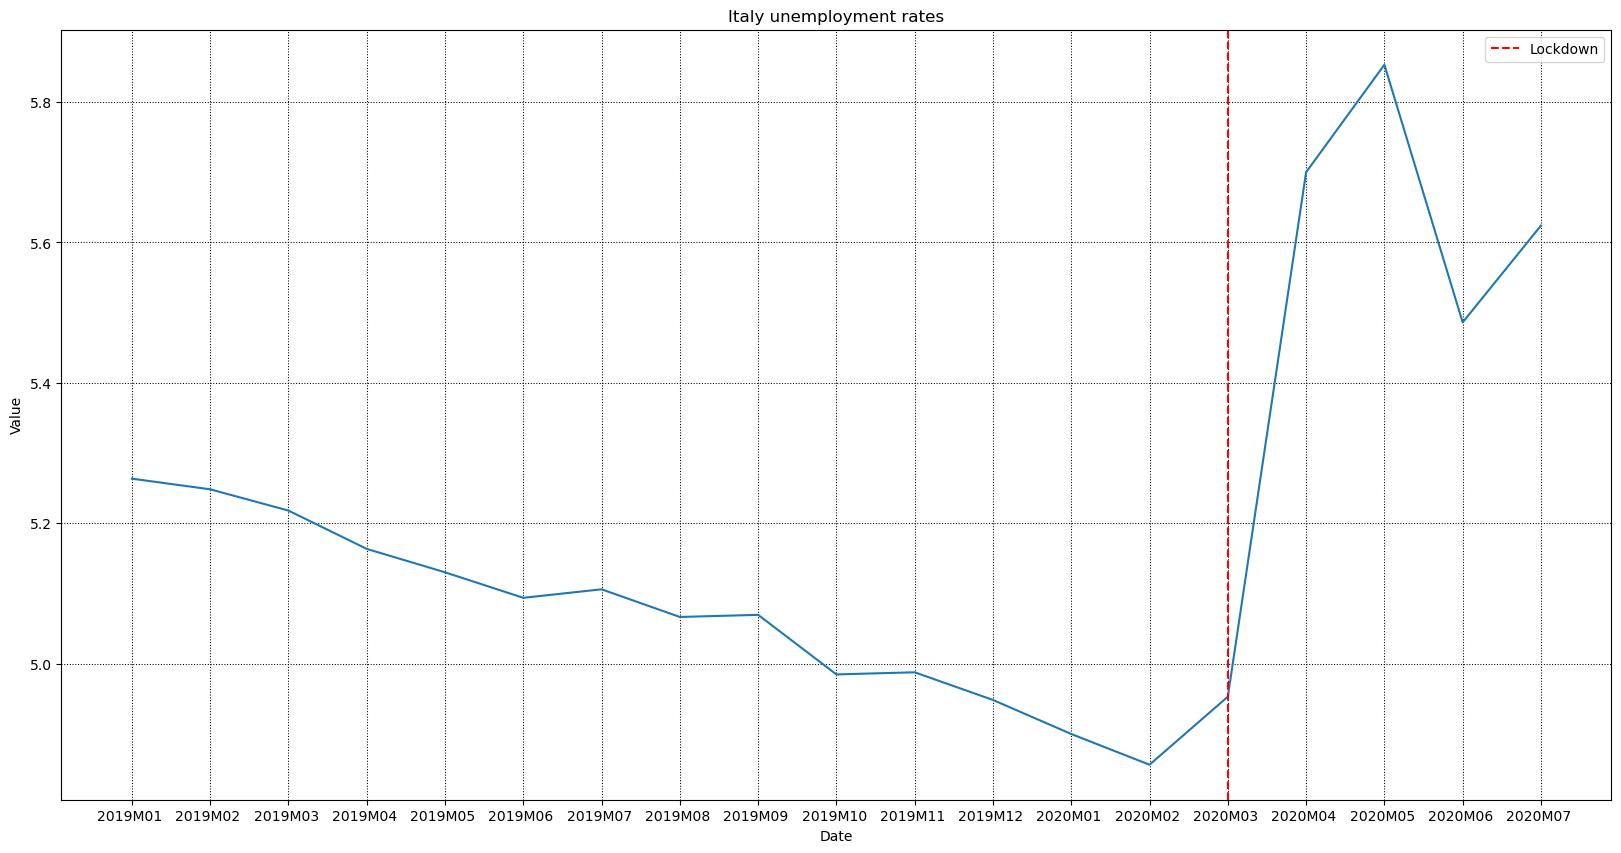

In [80]:
#Select the relevant rows of the dataset we wish to plot
total_y25_74_df = dfts.loc[(dfts.age=='Y25-74')&(dfts.unit=='PC_ACT')&(dfts.sex=='T')]
#plot the data
plt.figure(figsize=(20, 10))
sns.lineplot(x=np.flip(total_y25_74_df["Date"]), y=np.flip(total_y25_74_df['Value']), errorbar=None)
plt.axvline(x=total_y25_74_df["Date"].iloc[130],color='red', linestyle='--', label='Lockdown')
plt.title('Italy unemployment rates') 
plt.grid(color='black', linestyle='dotted', linewidth=0.75)
plt.legend()
#plt.xticks(rotation=90)
plt.show()

We have now cleaned and visualized data from this data set that can prove useful to quantify changes in the safety needs category of Maslow's hierarchy of needs. We already observe a difference between pre and post lockdown measures, a difference which will be more rigorously analysed in the following milestone. 